In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import re
from torch import nn
from tqdm import tqdm
import torch.optim as optim
import torch
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from eli5.permutation_importance import get_score_importances
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc

## Data preparation

In [2]:
dataPath = '../data/dataset.csv'
resultsPath = '../results/clustering'

In [3]:
data = pd.read_csv(dataPath)

In [4]:
def identifyPatient(x):
    if 'PD' in x:
        return 'PD'
    elif 'RBD' in x:
        return 'RBD'
    else:
        return 'HC'

In [5]:
data['patientType'] = data[' Participant  code '].apply(identifyPatient)

In [6]:
data['patientType'].value_counts()

RBD    50
HC     50
PD     30
Name: patientType, dtype: int64

In [7]:
specialcols = [' Antidepressant  therapy ', ' Benzodiazepine  medication ']
for col in specialcols:
    data[f'{col}name'] = data[col].apply(lambda x: re.search('[aA-zZ]+', x.split(' ')[3]).group(0) if x!= 'No' else x)
    data[col] = data[col].apply(lambda x: x.split(' ')[1] if x!= 'No' else x)

### Checking for missing values

In [8]:
for col in data.columns:
    data.loc[data[col]=='-',col] = np.nan

In [9]:
for col in data.columns:
    print(f'{col}: {pd.isnull(data[col]).sum()}')

 Participant  code : 0
 Age  (years) : 0
Gender: 0
 Positive  history  of  Parkinson  disease  in  family : 50
 Age  of  disease  onset  (years) : 50
 Duration  of  disease  from  first  symptoms  (years) : 50
 Antidepressant  therapy : 0
 Antiparkinsonian  medication : 0
 Antipsychotic  medication : 0
 Benzodiazepine  medication : 0
 Levodopa  equivalent  (mg/day) : 0
 Clonazepam  (mg/day) : 0
 Overview  of  motor  examination:  Hoehn  &  Yahr  scale  (-) : 100
 Overview  of  motor  examination:  UPDRS  III  total  (-) : 50
 18.  Speech : 50
 19.  Facial  Expression : 50
 20.  Tremor  at  Rest  -  head : 50
 20.  Tremor  at  Rest  -  RUE : 50
 20.  Tremor  at  Rest  -  LUE : 50
 20.  Tremor  at  Rest  -  RLE : 50
 20.  Tremor  at  Rest  -  LLE : 50
 21.  Action  or  Postural  Tremor  -  RUE : 50
 21.  Action  or  Postural  Tremor  -  LUE : 50
 22.  Rigidity  -  neck : 50
 22.  Rigidity  -  RUE : 50
 22.  Rigidity  -  LUE : 50
 22.  Rigidity  -  RLE : 50
 22.  Rigidity  -  LLE : 50
 23

### Looking at the unique values for each column to understand the information better

In [10]:
for col in data.columns:
    print(col)
    print(data[col].unique())

 Participant  code 
['PD01' 'PD02' 'PD03' 'PD04' 'PD05' 'PD06' 'PD07' 'PD08' 'PD09' 'PD10'
 'PD11' 'PD12' 'PD13' 'PD14' 'PD15' 'PD16' 'PD17' 'PD18' 'PD19' 'PD20'
 'PD21' 'PD22' 'PD23' 'PD24' 'PD25' 'PD26' 'PD27' 'PD28' 'PD29' 'PD30'
 'RBD01' 'RBD02' 'RBD03' 'RBD04' 'RBD05' 'RBD06' 'RBD07' 'RBD08' 'RBD09'
 'RBD10' 'RBD11' 'RBD12' 'RBD13' 'RBD14' 'RBD15' 'RBD16' 'RBD17' 'RBD18'
 'RBD19' 'RBD20' 'RBD21' 'RBD22' 'RBD23' 'RBD24' 'RBD25' 'RBD26' 'RBD27'
 'RBD28' 'RBD29' 'RBD30' 'RBD31' 'RBD32' 'RBD33' 'RBD34' 'RBD35' 'RBD36'
 'RBD37' 'RBD38' 'RBD39' 'RBD40' 'RBD41' 'RBD42' 'RBD43' 'RBD44' 'RBD45'
 'RBD46' 'RBD47' 'RBD48' 'RBD49' 'RBD50' 'HC01' 'HC02' 'HC03' 'HC04'
 'HC05' 'HC06' 'HC07' 'HC08' 'HC09' 'HC10' 'HC11' 'HC12' 'HC13' 'HC14'
 'HC15' 'HC16' 'HC17' 'HC18' 'HC19' 'HC20' 'HC21' 'HC22' 'HC23' 'HC24'
 'HC25' 'HC26' 'HC27' 'HC28' 'HC29' 'HC30' 'HC31' 'HC32' 'HC33' 'HC34'
 'HC35' 'HC36' 'HC37' 'HC38' 'HC39' 'HC40' 'HC41' 'HC42' 'HC43' 'HC44'
 'HC45' 'HC46' 'HC47' 'HC48' 'HC49' 'HC50']
 Age 

### Segregating the columns by their type so they can be processed accordingly

In [11]:
categorical = ['Gender', ' Antidepressant  therapy ',
            ' Benzodiazepine  medication ']
ordinal_categorical = [' 18.  Speech ', ' 19.  Facial  Expression ',' 20.  Tremor  at  Rest  -  head ', ' 20.  Tremor  at  Rest  -  RUE ',
       ' 20.  Tremor  at  Rest  -  LUE ', ' 20.  Tremor  at  Rest  -  RLE ',' 20.  Tremor  at  Rest  -  LLE ',
       ' 21.  Action  or  Postural  Tremor  -  RUE ',' 21.  Action  or  Postural  Tremor  -  LUE ',
       ' 22.  Rigidity  -  neck ', ' 22.  Rigidity  -  RUE ',' 22.  Rigidity  -  LUE ', ' 22.  Rigidity  -  RLE ',
       ' 22.  Rigidity  -  LLE ', ' 23.Finger  Taps  -  RUE ',' 23.Finger  Taps  -  LUE ', ' 24.  Hand  Movements  -  RUE ',
       ' 24.  Hand  Movements  -  LUE ',' 25.  Rapid  Alternating  Movements  -  RUE ',
       ' 25.  Rapid  Alternating  Movements  -  LUE ',' 26.  Leg  Agility  -  RLE ', ' 26.  Leg  Agility  -  LLE ',
       ' 27.  Arising  from  Chair   ', ' 28.  Posture ', ' 29.  Gait ',' 30.  Postural  Stability ',
       ' 31.  Body  Bradykinesia  and  Hypokinesia ']
numerical = [' Age  (years) ', ' Entropy  of  speech  timing  (-) ',' Rate  of  speech  timing  (-/min) ',
       ' Acceleration  of  speech  timing  (-/min2) ',' Duration  of  pause  intervals  (ms) ',
       ' Duration  of  voiced  intervals  (ms) ',' Gaping  in-between  voiced  intervals  (-/min) ',
       ' Duration  of  unvoiced  stops  (ms) ',' Decay  of  unvoiced  fricatives  (‰/min) ',
       ' Relative  loudness  of  respiration  (dB) ',' Pause  intervals  per  respiration  (-) ',
       ' Rate  of  speech  respiration  (-/min) ',' Latency  of  respiratory  exchange  (ms) ',
       ' Entropy  of  speech  timing  (-) .1',' Rate  of  speech  timing  (-/min) .1',
       ' Acceleration  of  speech  timing  (-/min2) .1',' Duration  of  pause  intervals  (ms) .1',
       ' Duration  of  voiced  intervals  (ms) .1',' Gaping  in-between  voiced  Intervals  (-/min) ',
       ' Duration  of  unvoiced  stops  (ms) .1',' Decay  of  unvoiced  fricatives  (‰/min) .1',
       ' Relative  loudness  of  respiration  (dB) .1',' Pause  intervals  per  respiration  (-) .1',
       ' Rate  of  speech  respiration  (-/min) .1',' Latency  of  respiratory  exchange  (ms) .1']
othercols = [' Overview  of  motor  examination:  UPDRS  III  total  (-) ']
allcols = categorical + ordinal_categorical + numerical + othercols
outputcol = ['patientType']

## One-hot encoding categorical variables

In [12]:
new_data = data[allcols]
for col in categorical:
    df = pd.get_dummies(new_data[col], prefix=col)
    min_col = {}
    for cols in df.columns:
        min_col[cols] = df[cols].sum()
        dropcol = min(min_col.items(), key=lambda x: x[1])[0]
    df = df.drop(columns=dropcol)
    new_data = new_data.drop(columns=col)
    new_data = pd.concat([new_data,df], axis=1)

### All the missing data in ordinal variables is for healthy patients, assuming that its safe to impute this data with values that indicate normal functioning 

In [13]:
for col in ordinal_categorical:
    n = data[pd.isnull(data[col])]['patientType'].unique()
    print(f'{col}: {n}')
    new_data.loc[pd.isnull(new_data[col]),col] = '0'
    new_data[col] = new_data[col].apply(lambda x: int(x))

 18.  Speech : ['HC']
 19.  Facial  Expression : ['HC']
 20.  Tremor  at  Rest  -  head : ['HC']
 20.  Tremor  at  Rest  -  RUE : ['HC']
 20.  Tremor  at  Rest  -  LUE : ['HC']
 20.  Tremor  at  Rest  -  RLE : ['HC']
 20.  Tremor  at  Rest  -  LLE : ['HC']
 21.  Action  or  Postural  Tremor  -  RUE : ['HC']
 21.  Action  or  Postural  Tremor  -  LUE : ['HC']
 22.  Rigidity  -  neck : ['HC']
 22.  Rigidity  -  RUE : ['HC']
 22.  Rigidity  -  LUE : ['HC']
 22.  Rigidity  -  RLE : ['HC']
 22.  Rigidity  -  LLE : ['HC']
 23.Finger  Taps  -  RUE : ['HC']
 23.Finger  Taps  -  LUE : ['HC']
 24.  Hand  Movements  -  RUE : ['HC']
 24.  Hand  Movements  -  LUE : ['HC']
 25.  Rapid  Alternating  Movements  -  RUE : ['HC']
 25.  Rapid  Alternating  Movements  -  LUE : ['HC']
 26.  Leg  Agility  -  RLE : ['HC']
 26.  Leg  Agility  -  LLE : ['HC']
 27.  Arising  from  Chair   : ['HC']
 28.  Posture : ['HC']
 29.  Gait : ['HC']
 30.  Postural  Stability : ['HC']
 31.  Body  Bradykinesia  and  Hypokin

In [14]:
for col in othercols:
    new_data.loc[pd.isnull(new_data[col]),col] = '0'
    new_data[col] = new_data[col].apply(lambda x: float(x))
    mean = new_data[col].mean()
    std = new_data[col].std()
    new_data[f'{col}_z'] = (new_data[col]-mean)/std
    new_data = new_data.drop(columns = col)

## Normalising numerical variables

In [15]:
for col in numerical:
    mean = new_data[col].mean()
    std = new_data[col].std()
    new_data[f'{col}_z'] = (new_data[col]-mean)/std
    new_data = new_data.drop(columns = col)

## Preparing output

In [16]:
out = []
for i in range(len(new_data)):
    if (data.loc[i, 'patientType'] == 'PD') | (data.loc[i, 'patientType'] == 'RBD'):
        out.append(1)
    else:
        out.append(0) 
        
out = np.array(out)
out = out.reshape(-1,1)
out = out.astype(np.float32)
out = torch.tensor(out)
out.shape

torch.Size([130, 1])

## Getting input and output arrays

In [17]:
inp = new_data.values
inp = inp.astype(np.float32)
inp = torch.tensor(inp)

In [18]:
print(f'Input array shape: {inp.shape}')
print(f'Output array shape: {out.shape}')

Input array shape: torch.Size([130, 56])
Output array shape: torch.Size([130, 1])


## Stratified Cross validation

In [19]:
skf = StratifiedKFold(n_splits=3)

## Building model
## Model 1 - Healthy vs Unhealthy

### Adopting a heirarchical approach towards modelling. First model is to identify healthy and unhealthy patients. Unhealthy patients include both early onset untreated parkinson's disease patients and patients with RBD

In [20]:
class model(nn.Module):
    def __init__(self, n_inputs, n_outputs, n_layers, n_units, activation):
        super(model, self).__init__()
        network = []
        for n in range(n_layers):
            if n==0:
                network.extend([nn.Linear(n_inputs, n_units[n]), activation[n]])
            elif n==n_layers-1:
                network.extend([nn.Linear(n_units[n-1], n_outputs), activation[n]])
            else:
                network.extend([nn.Linear(n_units[n-1], n_units[n]), activation[n]])
        self.model = nn.Sequential(*network)
    def forward(self, x):
        output = self.model(x)
        return output
    def plot_loss(self, loss_epo):
        plt.plot(loss_epo.keys(), loss_epo.values())
    def performance_measures(self, y_true, y_pred):
        accuracy = round(accuracy_score(y_true, y_pred), 2)
        precision = round(precision_score(y_true, y_pred), 2)
        recall = round(recall_score(y_true, y_pred), 2)
        f1 = round(recall_score(y_true, y_pred), 2)
        return accuracy, precision, recall, f1
    def calculate_performance(self, target, prediction, threshold):
        F1_score = {}
        perf = {}
        prediction = prediction.detach().numpy()
        for th in threshold:
            pred = prediction.copy()
            pred[pred>=th] = 1
            pred[pred<th] = 0
            F1_score[th] = f1_score(target, pred)
        max_th = max(F1_score.items(), key=lambda x: x[1])[0]
        binary = prediction.copy()
        binary[binary>=th] = 1
        binary[binary<th] = 0
        clf_matrix = confusion_matrix(target, binary)
        accuracy, precision, recall, f1 = self.performance_measures(target, binary)
        fpr, tpr, _ = roc_curve(target, prediction)
        roc_auc = auc(fpr, tpr)
        perf['conf_matrix'] = clf_matrix
        perf['accuracy'] = accuracy
        perf['precision'] = precision
        perf['recall'] = recall
        perf['f1'] = f1
        perf['auroc'] = roc_auc
        perf['max_thresh'] = max_th
        return perf

In [21]:
n_inputs = inp.shape[1]
n_outputs = 1
n_layers = 3
n_units = [20, 20, 20]
activation = [nn.Tanh(), nn.Tanh(), nn.Sigmoid()]

### 3-fold stratified cross validation to identify the best hyperparameters and neural network architecture for model

In [22]:
mymodel = model(n_inputs, n_outputs, n_layers, n_units, activation)
n_epochs = 100
loss_obj = nn.BCELoss()
optimizer = optim.Adam(mymodel.parameters(), lr=0.001)
loss_epo = {}
performance = {}
fold=0
torch.manual_seed(42)
for train_index, test_index in skf.split(inp, out):
    X_train, X_test = inp[train_index],inp[test_index]
    y_train, y_test = out[train_index], out[test_index]
    for i in tqdm(range(n_epochs)):
        mymodel.train()
        prediction = mymodel(X_train)
        loss = loss_obj(prediction, y_train)
        loss_epo[i] = loss.detach().numpy()
        loss.backward()
        optimizer.step()
        mymodel.zero_grad()
    mymodel.eval()
    with torch.no_grad():
        pred_test = mymodel(X_test)
        perf=mymodel.calculate_performance(y_test, pred_test, np.arange(0, 1, 0.1))
        performance[f'Fold_{fold}'] = perf
    fold+=1

100%|██████████| 100/100 [00:00<00:00, 1527.65it/s]


### The performance shows quite stable results for every fold

In [23]:
performance

{'Fold_0': {'conf_matrix': array([[16,  1],
         [ 0, 27]]),
  'accuracy': 0.98,
  'precision': 0.96,
  'recall': 1.0,
  'f1': 1.0,
  'auroc': 1.0,
  'max_thresh': 0.9},
 'Fold_1': {'conf_matrix': array([[16,  0],
         [ 6, 21]]),
  'accuracy': 0.86,
  'precision': 1.0,
  'recall': 0.78,
  'f1': 0.78,
  'auroc': 0.9444444444444444,
  'max_thresh': 0.30000000000000004},
 'Fold_2': {'conf_matrix': array([[17,  0],
         [ 4, 22]]),
  'accuracy': 0.91,
  'precision': 1.0,
  'recall': 0.85,
  'f1': 0.85,
  'auroc': 1.0,
  'max_thresh': 0.2}}

### Train-test split to calculate model performance on test data

In [24]:
X_train, X_test, y_train, y_test = train_test_split(inp, out, test_size=0.2, random_state=42, stratify=out)

In [25]:
mymodel = model(n_inputs, n_outputs, n_layers, n_units, activation)
n_epochs = 100
loss_obj = nn.BCELoss()
optimizer = optim.Adam(mymodel.parameters(), lr=0.001)
loss_epo = {}
performance = {}
torch.manual_seed(42)
for i in tqdm(range(n_epochs)):
    mymodel.train()
    prediction = mymodel(X_train)
    loss = loss_obj(prediction, y_train)
    loss_epo[i] = loss.detach().numpy()    
    loss.backward()
    optimizer.step()
    mymodel.zero_grad()
mymodel.eval()
with torch.no_grad():
    pred_test = mymodel(X_test)
    perf=mymodel.calculate_performance(y_test, pred_test,  np.arange(0, 1, 0.1))
    print(perf)

100%|██████████| 100/100 [00:00<00:00, 1240.13it/s]

{'conf_matrix': array([[ 9,  1],
       [ 4, 12]]), 'accuracy': 0.81, 'precision': 0.92, 'recall': 0.75, 'f1': 0.75, 'auroc': 0.93125, 'max_thresh': 0.8}


# Feature Importance - Permutation importance

### This analysis helps in identifying the factors which the model indicate are important in predicting the health of a patient

In [26]:
def score(X, y):
    y_pred = mymodel(torch.tensor(X))
    fpr, tpr, _ = roc_curve(y, y_pred.detach().numpy())
    roc_auc = auc(fpr, tpr)
    return roc_auc

In [27]:
base_score, score_decreases = get_score_importances(score, X_test.detach().numpy(), y_test.detach().numpy())
feature_importances = np.mean(score_decreases, axis=0)

In [28]:
fimp = {}
i=0
for col in new_data.columns:
    fimp[col] = feature_importances[i]
    i+=1

In [29]:
sort_fimp = sorted(fimp.items(), key=lambda x: x[1], reverse=True)

In [30]:
lab = [x[0] for x in sort_fimp][0:10]
val = [x[1] for x in sort_fimp][0:10]

Text(0.5, 0, 'Feature importance score')

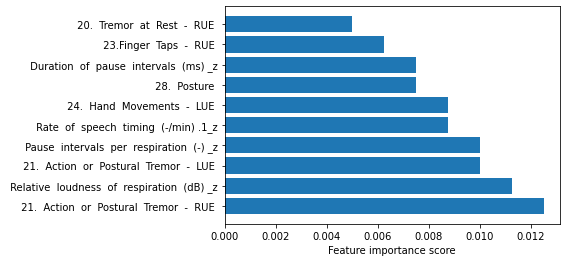

In [31]:
plt.barh(lab, val)
plt.xlabel('Feature importance score')

### If we look at exploratory data analysis, in a lot of variables which are identified as important by the model, there is a significant difference in distributions of Healthy and Unhealth patients

## Model 2 - PD and RBD

### This model is built to predict if a patient is suffering parkinson or RBD 

## Preparing data

In [32]:
sub_data = data[['patientType',' Age  of  disease  onset  (years) ',' Duration  of  disease  from  first  symptoms  (years) ']]
pd_data = pd.concat([new_data, sub_data], axis=1)
pd_data = pd_data[pd_data['patientType']!='HC']

In [33]:
newcols = [' Age  of  disease  onset  (years) ',' Duration  of  disease  from  first  symptoms  (years) ']
for col in newcols:
    pd_data[col] = pd_data[col].apply(lambda x: float(x))
    mean = pd_data[col].mean()
    std = pd_data[col].std()
    pd_data[f'{col}_z'] = (pd_data[col]-mean)/std
    pd_data = pd_data.drop(columns = col)

In [34]:
output = pd_data['patientType'] 

In [35]:
pd_data = pd_data.drop(columns=['patientType', ' Age  (years) _z'])

In [36]:
list(pd_data.columns).index(' Overview  of  motor  examination:  UPDRS  III  total  (-) _z')

30

In [37]:
out = []
for i in output:
    if i == 'PD':
        out.append(1)
    else:
        out.append(0) 
        
out = np.array(out)
out = out.reshape(-1,1)
out = out.astype(np.float32)
out = torch.tensor(out)
out.shape

torch.Size([80, 1])

In [38]:
inp = pd_data.values
inp = inp.astype(np.float32)
inp = torch.tensor(inp)

In [39]:
print(f'Input array shape: {inp.shape}')
print(f'Output array shape: {out.shape}')

Input array shape: torch.Size([80, 57])
Output array shape: torch.Size([80, 1])


### 3-fold Stratified cross validation

In [40]:
n_inputs = inp.shape[1]
n_outputs = 1
n_layers = 3
n_units = [20,10, 10]
activation = [nn.Tanh(),nn.Tanh(), nn.Sigmoid()]

In [41]:
mymodel = model(n_inputs, n_outputs, n_layers, n_units, activation)
n_epochs = 100
loss_obj = nn.BCELoss()
optimizer = optim.Adam(mymodel.parameters(), lr=0.001)
loss_epo = {}
performance = {}
fold=0
torch.manual_seed(42)
for train_index, test_index in skf.split(inp, out):
    X_train, X_test = inp[train_index],inp[test_index]
    y_train, y_test = out[train_index], out[test_index]
    for i in tqdm(range(n_epochs)):
        mymodel.train()
        prediction = mymodel(X_train)
        loss = loss_obj(prediction, y_train)
        loss_epo[i] = loss.detach().numpy()
        loss.backward()
        optimizer.step()
        mymodel.zero_grad()
    mymodel.eval()
    with torch.no_grad():
        pred_test = mymodel(X_test)
        perf=mymodel.calculate_performance(y_test, pred_test, np.arange(0, 1, 0.1))
        performance[f'Fold_{fold}'] = perf
    fold+=1

100%|██████████| 100/100 [00:00<00:00, 1569.31it/s]


In [42]:
performance

{'Fold_0': {'conf_matrix': array([[16,  1],
         [ 3,  7]]),
  'accuracy': 0.85,
  'precision': 0.88,
  'recall': 0.7,
  'f1': 0.7,
  'auroc': 0.9,
  'max_thresh': 0.9},
 'Fold_1': {'conf_matrix': array([[17,  0],
         [ 5,  5]]),
  'accuracy': 0.81,
  'precision': 1.0,
  'recall': 0.5,
  'f1': 0.5,
  'auroc': 0.9529411764705882,
  'max_thresh': 0.8},
 'Fold_2': {'conf_matrix': array([[16,  0],
         [ 6,  4]]),
  'accuracy': 0.77,
  'precision': 1.0,
  'recall': 0.4,
  'f1': 0.4,
  'auroc': 0.99375,
  'max_thresh': 0.1}}

In [43]:
X_train, X_test, y_train, y_test = train_test_split(inp, out, test_size=0.3, random_state=42, stratify=out)

In [44]:
mymodel = model(n_inputs, n_outputs, n_layers, n_units, activation)
n_epochs = 30
loss_obj = nn.BCELoss()
optimizer = optim.Adam(mymodel.parameters(), lr=0.001)
loss_epo = {}
performance = {}
torch.manual_seed(42)
for i in tqdm(range(n_epochs)):
    mymodel.train()
    prediction = mymodel(X_train)
    loss = loss_obj(prediction, y_train)
    loss_epo[i] = loss.detach().numpy()
    loss.backward()
    optimizer.step()
    mymodel.zero_grad()
mymodel.eval()
with torch.no_grad():
    pred_test = mymodel(X_test)
    perf=mymodel.calculate_performance(y_test, pred_test,  np.arange(0, 1, 0.2))
    print(perf)

100%|██████████| 30/30 [00:00<00:00, 1208.07it/s]

{'conf_matrix': array([[15,  0],
       [ 9,  0]]), 'accuracy': 0.62, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'auroc': 0.7703703703703704, 'max_thresh': 0.6000000000000001}



/Users/anisha/Documents/assignments/kaggle_parkinson/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Feature Importance

In [45]:
def score(X, y):
    y_pred = mymodel(torch.tensor(X))
    fpr, tpr, _ = roc_curve(y, y_pred.detach().numpy())
    roc_auc = auc(fpr, tpr)
    return roc_auc

In [46]:
base_score, score_decreases = get_score_importances(score, X_test.detach().numpy(), y_test.detach().numpy())
feature_importances = np.mean(score_decreases, axis=0)

In [47]:
fimp = {}
i=0
for col in new_data.columns:
    fimp[col] = feature_importances[i]
    i+=1
sort_fimp = sorted(fimp.items(), key=lambda x: x[1], reverse=True)
lab = [x[0] for x in sort_fimp][0:10]
val = [x[1] for x in sort_fimp][0:10]

Text(0.5, 0, 'Feature importance score')

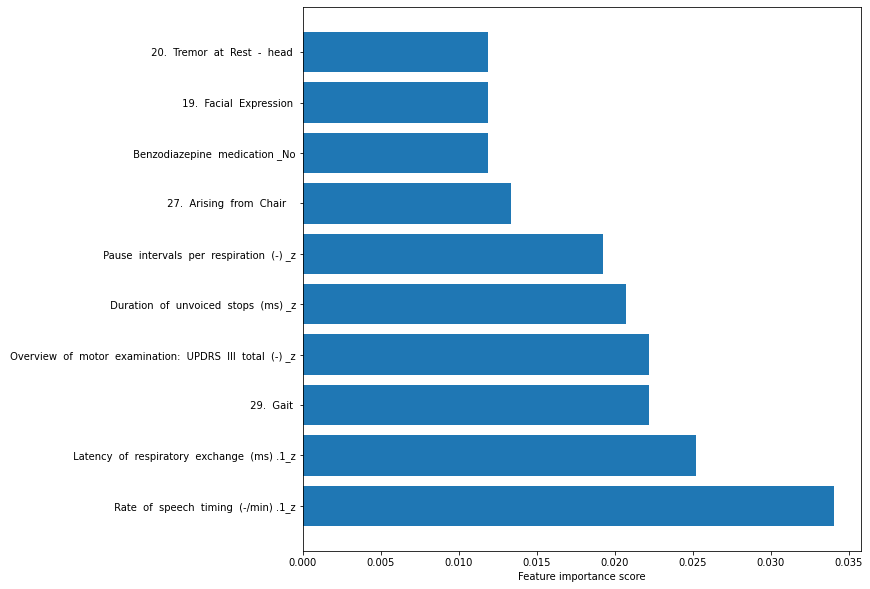

In [48]:
plt.figure(figsize=(10,10))
plt.barh(lab, val)
plt.xlabel('Feature importance score')

### One of the most important factor here is UPDRS III scale which makes sense as this is a very comprehesive scale used to identify if a patient has parkinson's. Apart from that, other variables shown to be important have a significantly differetnt distribution among PD and RBD patients

# Simulation

In [49]:
predictions = mymodel(X_test)

In [50]:
predictions

tensor([[0.4785],
        [0.4742],
        [0.6164],
        [0.7064],
        [0.6264],
        [0.5024],
        [0.5402],
        [0.4799],
        [0.6714],
        [0.7723],
        [0.5102],
        [0.5985],
        [0.6806],
        [0.5669],
        [0.4355],
        [0.4905],
        [0.3713],
        [0.6005],
        [0.5518],
        [0.5492],
        [0.4389],
        [0.5261],
        [0.5513],
        [0.5081]], grad_fn=<SigmoidBackward>)

In [51]:
X_test

tensor([[ 0.0000,  1.0000,  0.0000,  ..., -0.2019, -0.0699,  2.9039],
        [ 0.0000,  0.0000,  1.0000,  ..., -0.7535,  1.0488, -0.7914],
        [ 0.0000,  1.0000,  1.0000,  ...,  0.1854,  0.8624, -0.2987],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., -1.5280, -0.5361, -0.7914],
        [ 0.0000,  2.0000,  0.0000,  ..., -0.5070,  0.0233,  3.1503],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.8826, -0.7225,  1.9185]])

In [52]:
predictions[5]

tensor([0.5024], grad_fn=<SelectBackward>)

In [53]:
predictions[predictions>=0.6] = 1
predictions[predictions<0.6] = 0

In [54]:
predictions

tensor([[0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<IndexPutBackward>)

In [55]:
patient_rbd = X_test[5, :].detach().numpy().copy()
patient_rbd[30] = 4.6931

In [56]:
mymodel(torch.tensor(patient_rbd))

tensor([0.6208], grad_fn=<SigmoidBackward>)

### The model predicted this patient as an RBD, simulation has been performed for this patients by keeping all other variables as same and varying only the UPDRS III scale, the value taken is maximum in the dataset. The prediction for this patient goes from 0.5 to 0.62 which makes him a PD patient. The model is able to capture the importance of UPDRS III scale in diagnosing Prakinson's

# Conclusion

### Both the models have a decent performance and are able to identify the important variables which are seen to be important in exploratory analysis as well. 